In [1]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import j1
from math import sqrt
from PIL import Image
import os
import tensorflow as tf
import pickle
from itertools import product
from common import generateParameters, DiffractionPatternGenerator, DiffMCMCSampler
%matplotlib inline

In [2]:
tf.config.experimental.list_logical_devices('GPU')

[LogicalDevice(name='/device:GPU:0', device_type='GPU')]

In [3]:
np.set_printoptions(suppress=True, precision=5)

$$I(x,y) = p_1 \cdot \left(a_1 \cdot b_1 \cdot \frac{J_1(\frac{k}{z}\sqrt{a_1^2x^2 + b_1^2y^2})}{\frac{k}{z}\sqrt{a_1^2x^2 + b_1^2y^2}}\right)^2 + p_2 \cdot \left(a_2 \cdot b_2 \cdot \frac{J_1(\frac{k}{z}\sqrt{a_2^2x^2 + b_2^2y^2})}{\frac{k}{z}\sqrt{a_2^2x^2 + b_2^2y^2}}\right)^2 $$

## Data generation

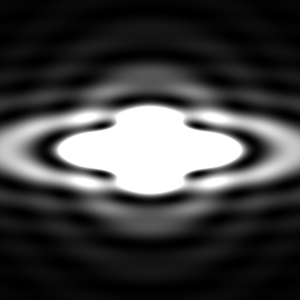

In [4]:
generator = DiffractionPatternGenerator()
im = Image.fromarray(generator.getPattern(generateParameters()).numpy() * 255)
im.convert("L").resize((300, 300))

## Metropolis-Hastings

In [5]:
#In this symmetrical case we can use only 1/4 of data
I_data = DiffractionPatternGenerator().getPattern(generateParameters())

$$\log{\mathcal{L}} 
= \log{\prod\limits_{i, j=1}^N{f(I_{ij}|x_i, y_j,\lambda, z, \theta)}}=
-N^2\cdot\log{\sigma\sqrt{2\pi}} - \sum_{i=1}^N\sum_{j=1}^N{\frac{(I_{ij} - I(x_i, y_j, \lambda, z, \theta))^2}{2\sigma^2}}$$

In [6]:
sampler = DiffMCMCSampler()

In [7]:
NUM_ITERATIONS = 10_000
INIT_APPROX = [0.5, 1.0, 1.0, 1.0, 1.0 , 0.1]
LEARNING_RATE  = 0.05

In [8]:
accepted, states, all_params = sampler.run_mcmc(INIT_APPROX, NUM_ITERATIONS, I_data, LEARNING_RATE)


In [9]:
accepted[-1]

array([0.30744, 4.01326, 3.96569, 8.04018, 1.99376, 0.06754])

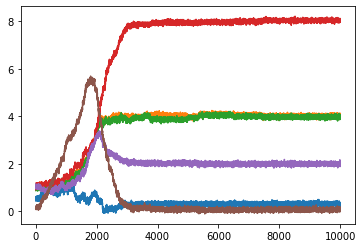

In [14]:
plt.plot(all_params)

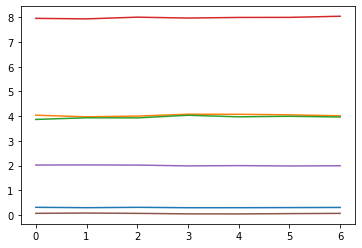

In [15]:
plt.plot(accepted)

In [40]:
generator_grid = {
    "elongation" : list(np.arange(1, 26, 1.)),
    "badcellperc": list(np.arange(0.1, 0.9, 0.05))
}

In [17]:
NUM_ITERATIONS = 4000
INIT_APPROX = [0.5, 1.0, 1.0, 1.0, 1.0 , 0.1]
LEARNING_RATE  = tf.constant(0.05)
def get_grid_results(grid):
    generator = DiffractionPatternGenerator()
    sampler = DiffMCMCSampler()
    keys, values = zip(*grid.items())
    res = []
    for g in tqdm(product(*values)):
        d = dict(zip(keys, g))
        true_params = generateParameters(**d)
        I_data = generator.getPattern(true_params)
        accepted, states, all_params = sampler.run_mcmc(
                                         INIT_APPROX, 
                                         NUM_ITERATIONS,
                                         [I_data],
                                         LEARNING_RATE)
        res.append((true_params, accepted, states, all_params))
    return res

In [18]:
res = get_grid_results(generator_grid)

400it [35:14,  5.29s/it]


In [41]:
 (len(generator_grid['elongation']), len(generator_grid['badcellperc']))

(25, 16)

In [19]:
pickle.dump(res, open("grid_res.pickle", 'wb'))

In [20]:
res = pickle.load(open("grid_res.pickle", "rb"))

In [228]:
par2index = {'p1':0,
            'a1':1,
            'b1':2,
            'a2':3,
            'b2':4,
            'sigma':5}

def plot_span(sampler_data):
    res_span = np.array(list(map(lambda x: abs(np.percentile(x[3], 95,axis=0) - np.percentile(x[3], 5,axis=0)), res)))
    res_span = res_span.reshape( (len(generator_grid['elongation']), len(generator_grid['badcellperc']), 6))
    xx, yy = pylab.meshgrid(generator_grid['badcellperc'], generator_grid['elongation'])
    def plot_for_parameter(ax, p_name):
        idx = par2index[p_name]
        ax.pcolor(xx, yy, res_span[:, :, idx])
        ax.set_xlabel('p1', fontsize=10)
        ax.set_ylabel('elongation', fontsize=10)
        ax.set_title(p_name, fontsize=20)
    
    fig = plt.figure()
    fig.suptitle('Ширина диапазона, в который попадают 95% точек', fontsize=32)
    fig.set_figheight(10)
    fig.set_figwidth(18)
    for i, k in enumerate(par2index.keys()):
        plot_for_parameter(plt.subplot2grid((2, 3), (i // 3,i%3)),k)
    
    #res_span_z = res_span[:, :, 1]
    #plt.pcolor(xx, yy, res_span_z)

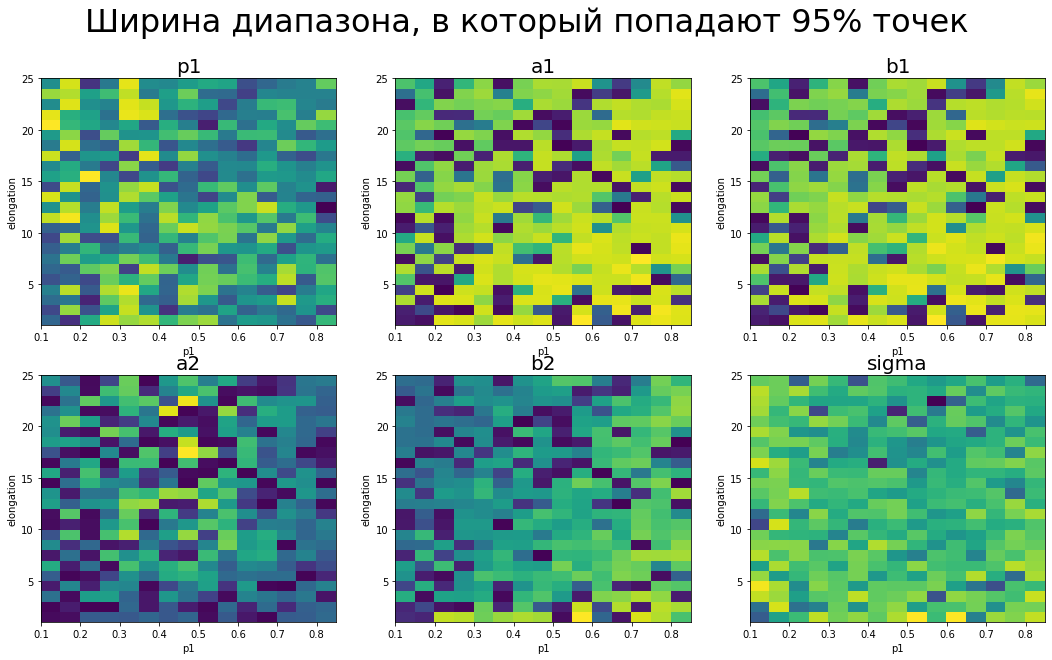

In [229]:
plot_span(res)

In [254]:
def plot_all_mse_sampler_data(sampler_data):
    data_shape = (len(generator_grid['elongation']), len(generator_grid['badcellperc']))
    
    res_accepted_last_mse = list(map(lambda x: ((x[0][:3]+x[0][4:] - x[1][-1][:-1]) ** 2).mean(), sampler_data))
    res_accepted_last_mse = np.reshape(res_accepted_last_mse, data_shape)
    
    res_accepted_median25_mse = list(map(lambda x: ((np.delete(x[0], 3) - np.percentile(x[1][int(x[1].shape[0]*0.5):,:-1], 50, axis=0)) ** 2).mean(), sampler_data))
    res_accepted_median25_mse = np.reshape(res_accepted_median25_mse, data_shape)
    
    res_accepted_median_mse = list(map(lambda x: ((np.delete(x[0], 3) - np.percentile(x[1][:,:-1], 50, axis=0)) ** 2).mean(), sampler_data))
    res_accepted_median_mse = np.reshape(res_accepted_median_mse, data_shape)

    res_last_mse = list(map(lambda x: ((x[0][:3]+x[0][4:] - x[3][-1][:-1]) ** 2).mean(), sampler_data))
    res_last_mse = np.reshape(res_last_mse, data_shape)
    
    res_median25_mse = list(map(lambda x: ((np.delete(x[0], 3) - np.percentile(x[3][int(x[1].shape[0]*0.5):,:-1], 50, axis=0)) ** 2).mean(), sampler_data))
    res_median25_mse = np.reshape(res_median25_mse, data_shape)
    
    res_median_mse = list(map(lambda x: ((np.delete(x[0], 3) - np.percentile(x[3][:,:-1], 50, axis=0)) ** 2).mean(), sampler_data))
    res_median_mse = np.reshape(res_median_mse, data_shape)
    
    fig = plt.figure()
    fig.suptitle('Различные ошибки', fontsize=32)
    fig.set_figheight(12)
    fig.set_figwidth(18)
    
    data = {
        'MSE for last accepted': res_accepted_last_mse,
        'MSE for median\n of last 50% of accepted': res_accepted_median25_mse,
        'MSE for median of accepted': res_accepted_median_mse,
        'MSE for last of all samples': res_last_mse,
        'MSE for median\n of last 50% of all samples': res_median25_mse,
        'MSE for median of all samples': res_median_mse
    }
    
    def plot_for_parameter(ax, plot_name):
        zz = data[plot_name]
        ax.pcolor(xx, yy, zz)
        ax.set_xlabel('p1', fontsize=10)
        ax.set_ylabel('elongation', fontsize=10)
        ax.set_title(plot_name, fontsize=20)
    
    for i, k in enumerate(data.keys()):
        plot_for_parameter(plt.subplot2grid((2, 3), (i // 3,i%3)),k)

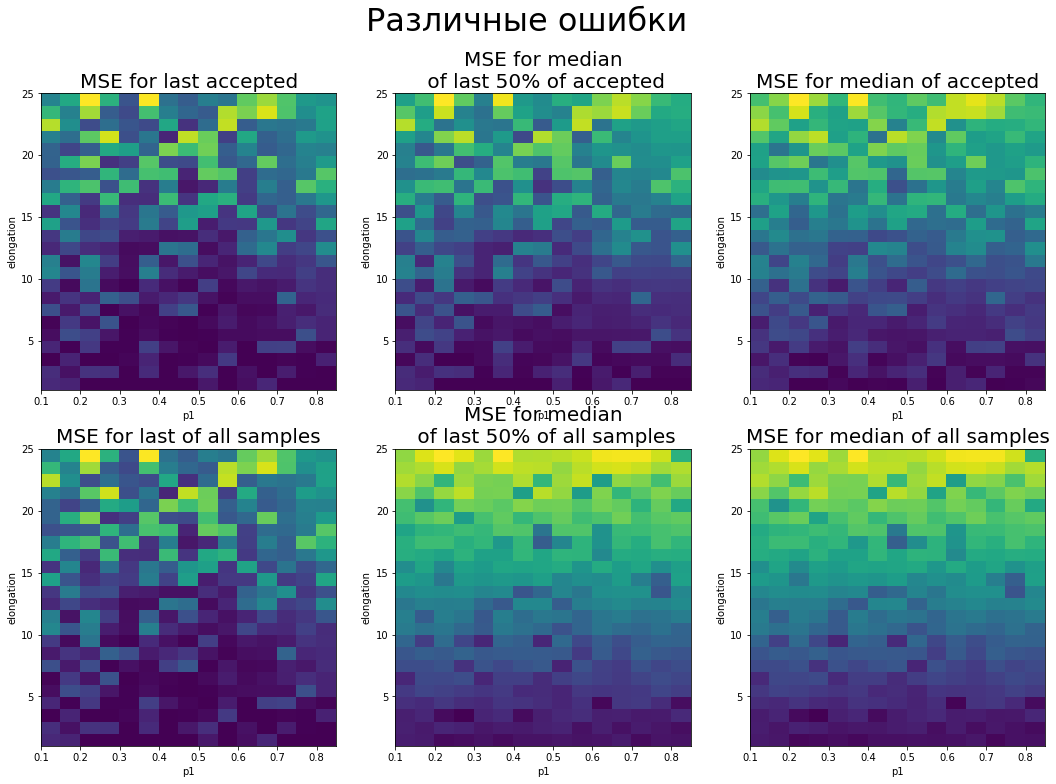

In [255]:
plot_all_mse_sampler_data(res)

In [256]:
def plot_p1(sampler_data):
    res_p1 = list(map(lambda x: abs(x[0][0] - x[1][-1][0]), sampler_data))
    res_p1 = np.reshape(res_p1, (len(generator_grid['elongation']), len(generator_grid['badcellperc'])))
    xx, yy = pylab.meshgrid(generator_grid['badcellperc'], generator_grid['elongation'])
    plt.title('AE of p1')
    plt.pcolor(xx, yy, res_p1)

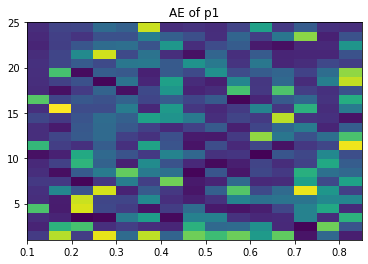

In [257]:
plot_p1(res)